In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import animation

In [2]:
M_tot = 10

R_max=10
N=10000

m = M_tot/N


Generate the particles 

In [3]:
random.seed(0)
phi=np.random.uniform(0,2*np.pi,N)
arc_theta=np.random.uniform(0,1,N)
theta=np.asarray([math.acos(1-2*arc_theta[i]) for i in range(N)])
C=np.random.uniform(0,1,N)
r=R_max*(C)**(1/3)

Write their positions in cartesian coordinates

In [4]:
X=r*np.sin(theta)*np.cos(phi)
Y=r*np.sin(theta)*np.sin(phi)
Z=r*np.cos(theta)

Show their positions and compute the center of mass

In [5]:
cm_x = np.sum(X)/N
cm_y = np.sum(Y)/N
cm_z = np.sum(Z)/N
print(cm_x,cm_y,cm_z)

0.02412907250627868 -0.0640798852390296 -0.009279207020913578


Save the initial position in an input file for the tree code

In [6]:
v=np.zeros(N)
M=np.ones(N)*m

np.savetxt('masses.txt', M)
np.savetxt('positions.txt',np.column_stack((X,Y,Z)))
np.savetxt('velocities.txt', np.column_stack((v,v,v)))

with open('initial_data.txt', 'w+') as file:
    file.write(repr(N)+'\n3\n0\n')
    file.write(open('masses.txt','r').read()+open('positions.txt','r').read()+open('velocities.txt','r').read())

# Simulation

Now we simulate the interactions between the particles in the positions we generated, we set their initial velocities as 0.

In [21]:
'''
open('output.txt', 'w').close()
os.system('./treecode in=initial_data.txt out=output.txt tstop=2 > logoutput.txt')
'''

"\nopen('output.txt', 'w').close()\nos.system('./treecode in=initial_data.txt out=output.txt tstop=2 > logoutput.txt')\n"

In [22]:
part_cubo = 200
V_tot = (4*np.pi*R_max**3)/3
V_cubo = V_tot/N * part_cubo
l = V_cubo**(1/3)


soft  = (V_tot/N)**(1/3)
#theta = l/R_max
theta = 1
dtime = 1/32
tstop = 15

open('output.txt', 'w').close()
os.system('./treecode in=initial_data.txt out=output.txt dtime='+str(dtime)+' eps='+str(soft)+' theta='+str(theta)+' tstop='+str(tstop)+' > logoutput.txt')


0

Read the output of the simulation and save the data

In [ ]:
data = pd.read_csv("output.txt", names=list(range(7)), sep = ' ')

In [24]:
def dati (data,N):
    
    x = []
    y = []
    z = []
    
    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
    
    r = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,r,t

In [25]:
x,y,z,r,time = dati(data, N)

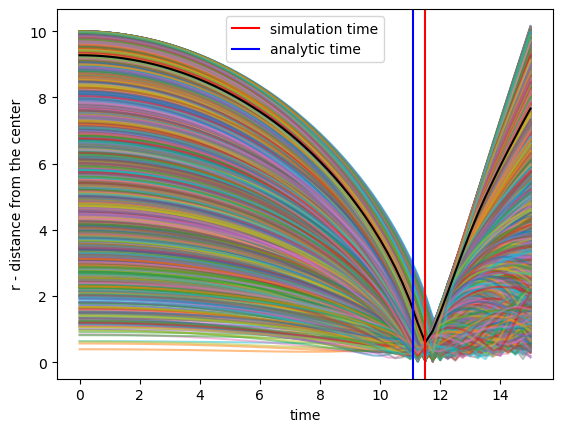

In [27]:
b = []
for i in range(len(time)):
    a    = np.sort(r[:,i])
    mask = a<np.quantile(a,0.8)
    b.append(np.max(a[mask]))
    
for i in range(N):
    plt.plot(time,r[i], alpha=0.5)

plt.plot(time,b, color='black')

t_sim = time[np.where(b==min(b))]

plt.xlabel('time')
plt.ylabel('r - distance from the center')
plt.axvline(t_sim,color='red', label='simulation time')
t =11.107207345395915
plt.axvline(t,color='blue', label='analytic time')
#plt.xlim(0,1)
#plt.ylim(0,20)
plt.legend()
plt.savefig('example')

# Analytic solution

To compute the collapse time analytically we can calculate the evolution in time of the different particles solving the following integral

$$\ddot{r}=-\frac{GM}{r^2}\dot{r}\qquad\Rightarrow\qquad  -\int_0^{t^\prime}\sqrt{2GM}dt = r_0^{3/2}\int_{r_0}^{r^\prime}\frac{\sqrt{\frac{r}{r_0}}d\frac{r}{r_0}}{\sqrt{1-\frac{r}{r_0}}}dr$$

$$ t^{\prime} = \frac{-\left(arcsin\sqrt{\frac{r^{\prime}}{r_0}}-\frac{\pi}{2}-\sqrt{\frac{r^{\prime}}{r_0}}\sqrt{1-\frac{r^{\prime}}{r_0}}\right) r_0^{3/2}}{\sqrt{2GM}} = \frac{-\left(arcsin\sqrt{\frac{r^{\prime}}{r_0}}-\frac{\pi}{2}-\sqrt{\frac{r^{\prime}}{r_0}}\sqrt{1-\frac{r^{\prime}}{r_0}}\right) R_{max}^{3/2}}{\sqrt{2mN}}$$

where we consider $G\equiv1$, since we use natural units, and $M$ as the mass contained in the sphere of radius r'.

In [14]:
def integral(r0, raggi, R_max,N,m):
    t = -((math.asin((raggi/r0)**0.5))-np.pi/2-((raggi/r0)**0.5*(1-raggi/r0)**0.5))/(8/3*np.pi*m*N/(4/3*np.pi*R_max**3))**0.5
    return t


raggi = np.array([np.linspace(0, r[i][0]) for i in range(len(r))])

t = []
for j in range (len(r)):
    t.append(np.array([integral(r[j][0],raggi[j][i],R_max,N,m) for i in range(len(raggi[j]))]))


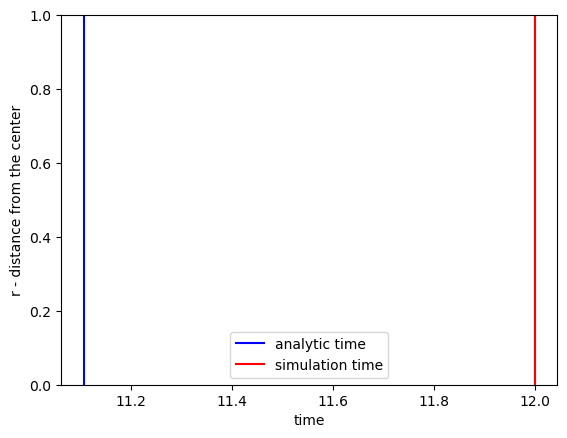

In [15]:
#for i in range (len(raggi)):
#    plt.plot(t[i], raggi[i], color='black', alpha=0.7)

plt.axvline(t[0][0],color='blue', label='analytic time')
plt.axvline(t_sim,color='red', label='simulation time')
plt.xlabel('time')
plt.ylabel('r - distance from the center')
plt.legend()
plt.show()

# Errors

Once we have defined how to find the simulation and the analytic collapse time we define the error as $\frac{t_{analytic}-t_{simulation}}{t_{analytic}}$.

# Simulation

Just to see what happens

In [17]:
'''numDataPoints = len(time)
def animate_func (num):
    
    ax.clear()
    x_ = np.array(x)
    y_ = np.array(y)
    z_ = np.array(z)
    for i in range(len(x_)):
        #Update trajectory line
        ax.plot3D(x_[i, :num+1], y_[i, :num+1], z_[i, :num+1])
        #Update point location
        #ax.scatter(z[i, num], y[i, num], z[i, num], marker='o')
        #Add constant origin
        #ax.plot3D(x[i, 0], y[i, 0], z[i, 0], c='black', marker ='o')
        
    #Axis limits
    ax.set_xlim3d([-10,10])
    ax.set_ylim3d([-10,10])
    ax.set_zlim3d([-10,10])
    
    
    #Figure labels
    #ax.set_title('Time =' + str(np.round((np.array(time))[num])))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 145)
    '''

"numDataPoints = len(time)\ndef animate_func (num):\n    \n    ax.clear()\n    x_ = np.array(x)\n    y_ = np.array(y)\n    z_ = np.array(z)\n    for i in range(len(x_)):\n        #Update trajectory line\n        ax.plot3D(x_[i, :num+1], y_[i, :num+1], z_[i, :num+1])\n        #Update point location\n        #ax.scatter(z[i, num], y[i, num], z[i, num], marker='o')\n        #Add constant origin\n        #ax.plot3D(x[i, 0], y[i, 0], z[i, 0], c='black', marker ='o')\n        \n    #Axis limits\n    ax.set_xlim3d([-10,10])\n    ax.set_ylim3d([-10,10])\n    ax.set_zlim3d([-10,10])\n    \n    \n    #Figure labels\n    #ax.set_title('Time =' + str(np.round((np.array(time))[num])))\n    ax.set_xlabel('x')\n    ax.set_ylabel('y')\n    ax.set_zlabel('z')\n    ax.view_init(30, 145)\n    "

In [18]:
'''#Plotting the animation
fig = plt.figure()
ax = plt.axes(projection='3d')
line_ani = animation.FuncAnimation(fig, animate_func, interval=10, frames=int(numDataPoints))

# Saving the Animation
# To change the speed of the animation, change fps. 60 should be enough
writergif = animation.PillowWriter(fps=60)
line_ani.save('collapse.gif', writer=writergif)'''

"#Plotting the animation\nfig = plt.figure()\nax = plt.axes(projection='3d')\nline_ani = animation.FuncAnimation(fig, animate_func, interval=10, frames=int(numDataPoints))\n\n# Saving the Animation\n# To change the speed of the animation, change fps. 60 should be enough\nwritergif = animation.PillowWriter(fps=60)\nline_ani.save('collapse.gif', writer=writergif)"